# FASHION GAN #

## Dependencies ##

In [1]:
import os
import h5py
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import pickle
import math
import sys

#Custom libraries
from Downsampling import GetSegmentationImageReady, OneHotEncodingImage, DownsizeAttributes, DownsampleImage, normalize_image
from Gans import Generator1, Discriminator1, Generator2, Discriminator2, initGans
import DeepFashDataset

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
print("Using device: {}".format(device))
generator1, discriminator1, generator2, discriminator2 = initGans(device)

Using device: cuda:0


In [7]:
# Load images
import h5py
Data_G2 = h5py.File('Data/G2.h5', 'r')
segmentatedImages = Data_G2['b_']
# Load attributes
from scipy.io import loadmat
Data_matlab = loadmat('Data/language_original.mat')
ind = loadmat('Data/ind.mat')

## Preprocessing (Remove outcomment to run once) ## 

In [3]:
## Creates a new dataset
"""
CreatedDataSet = h5py.File('Data/CreatedDataSet.h5', 'w')
print(type(CreatedDataSet))

## Creates new group
DownsampleGrp = CreatedDataSet.create_group("downsampledImg")
print(DownsampleGrp.name)

## Creates new dataset
DownsampleGrp.create_dataset("downsampledData", (Data_G2['b_'].shape[0], 4, 8, 8), dtype='i8')
#DownsampleGrp.create_dataset("downsampledOnehot", (Data_G2['b_'].shape[0], 4, 128, 128), dtype='i8')


downsampledData = CreatedDataSet['downsampledImg']["downsampledData"]
print(downsampledData.shape)


numberOfIter = downsampledData.shape[0]
for i in range(numberOfIter):
  if i % 5000 == 0:
    print("{} out of {}".format(i, numberOfIter))
  segmentatedImage = segmentatedImages[i]
  downsizedImage = DownsizeAttributes(segmentatedImage)
  oneHotEncodedImage = OneHotEncodingImage(downsizedImage[0], 4)
  #downsampledOnehot[i] = oneHotEncodedImage 
  downsampledImage = np.empty((4,8,8))
  downsampleSize =(8,8)
  downsampledImage[0] = DownsampleImage(oneHotEncodedImage[0], downsampleSize)
  downsampledImage[1] = DownsampleImage(oneHotEncodedImage[1], downsampleSize)
  downsampledImage[2] = DownsampleImage(oneHotEncodedImage[2], downsampleSize)
  downsampledImage[3] = DownsampleImage(oneHotEncodedImage[3], downsampleSize)
  downsampledData[i] = downsampledImage

print("Done")
CreatedDataSet.close()"""

<class 'h5py._hl.files.File'>
/downsampledImg
(78979, 4, 8, 8)
0 out of 78979
5000 out of 78979
10000 out of 78979
15000 out of 78979
20000 out of 78979
25000 out of 78979
30000 out of 78979
35000 out of 78979
40000 out of 78979
45000 out of 78979
50000 out of 78979
55000 out of 78979
60000 out of 78979
65000 out of 78979
70000 out of 78979
75000 out of 78979
Done


In [5]:
"""import pandas as pd
from AttributeRetriever import allAttributes
columns = ["ID", "Height", "Width", "BodyRatio", "HasLongHair", "R_mean", "G_mean", 
           "B_mean", "Y_mean", "Gender"]
skipIDs = [7743, 38494, 39961, 61881, 71252, 74775, 76916, 77083]

attrList = []
for ID in range(len(Data_G2['ih'])):
    if ID in skipIDs:
        attrList.append(allAttributes(ID, Data_G2, Data_matlab, True))
    else:
        attrList.append(allAttributes(ID, Data_G2, Data_matlab, False))
    
    # Show progress
    if len(attrList)%2500 == 0:
        print("{} / {}".format(ID+1, len(Data_G2['ih'])))  

df = pd.DataFrame(data=attrList, columns=columns)
df = df.set_index("ID")"""

### RNN

In [8]:
"""def cleaning_data(data):
  #Cleaning data by removing unnecessary tuples and type data. 
    cleaned_data = []
    for i in range(len(data)):
        temp = data[i][0]
        cleaned_data.append(temp.tolist())
    return cleaned_data



categories = torch.LongTensor(cleaning_data(Data_matlab["cate_new"]))
genders = torch.LongTensor(cleaning_data(Data_matlab['gender_']))
colors = torch.LongTensor(cleaning_data(Data_matlab['color_']))
sleeves = torch.LongTensor(cleaning_data(Data_matlab['sleeve_']))
codeJ = cleaning_data(Data_matlab['codeJ'])
train_ind = torch.LongTensor(cleaning_data(ind['train_ind']))"""

In [9]:
"""test_dim = 78979 # size of test set

data_cate_new = torch.IntTensor(test_dim, 1)
data_color = torch.IntTensor(test_dim, 1)
data_gender = torch.IntTensor(test_dim, 1)
data_sleeve = torch.IntTensor(test_dim, 1)
for i in range(test_dim):
    data_cate_new[i][0] = int(categories[i] - 1)
    data_color[i][0] = int(colors[i] - 1)
    data_gender[i][0] = int(genders[i])
    data_sleeve[i][0] = int(sleeves[i] - 1)


def attribute_sample(data_id, batchsize_dim):
    cuda_label_cate_new = Variable(torch.LongTensor(batchsize_dim).zero_().cuda())
    cuda_label_color = Variable(torch.LongTensor(batchsize_dim).zero_().cuda())
    cuda_label_gender = Variable(torch.LongTensor(batchsize_dim).zero_().cuda())
    cuda_label_sleeve = Variable(torch.LongTensor(batchsize_dim).zero_().cuda())

    cuda_label_cate_new.data[0] = data_cate_new[data_id]
    cuda_label_color.data[0] = data_color[data_id]
    cuda_label_gender.data[0] = data_gender[data_id]
    cuda_label_sleeve.data[0] = data_sleeve[data_id]

    return cuda_label_cate_new, cuda_label_color, cuda_label_gender, cuda_label_sleeve"""

In [10]:
"""def one_hot_encoding(words, vocab_size, batch_size):
    num_words = len(words)
    one_hot = torch.zeros(num_words, batch_size, vocab_size).cuda()
    for i in range(num_words):
        if one_hot[i][0][words[i][0]-1] != 1:
            one_hot[i][0][words[i][0]-1] = 1
    return one_hot"""

In [11]:
"""import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

vocab_dim = 539 # size of vocabulary
num_layers = 1
batchsize_dim = 1 #batch only 1 for convenience
hidden_dim = 41 # rnn hidden units
cate_new_dim = 19 # category of clothes
color_dim = 17 #color of clothes
gender_dim = 2 # gender
sleeve_dim = 4 # length of sleeve
test_dim = 78979 # size of test set
train_dim = 70000 # size of training set


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Recurrent layer
        self.lstm = nn.RNN(vocab_dim, hidden_dim, num_layers, bias=False)
        self.cate_new = nn.Linear(hidden_dim, cate_new_dim, bias=False)
        self.color = nn.Linear(hidden_dim, color_dim, bias=False)
        self.gender = nn.Linear(hidden_dim, gender_dim, bias=False)
        self.sleeve = nn.Linear(hidden_dim, sleeve_dim, bias=False)
        

        
    def forward(self, x):
        h_input = torch.zeros(num_layers, batchsize_dim, hidden_dim).cuda()
        _, hs = self.lstm(x, h_input)
        h = hs[-1] 
        y_cate_new = self.cate_new(h)
        y_color = self.color(h)
        y_gender = self.gender(h)
        y_sleeve = self.sleeve(h)

        return h, y_cate_new, y_color, y_gender, y_sleeve


net = Net()
net.cuda()"""

Net(
  (lstm): RNN(539, 41, bias=False)
  (cate_new): Linear(in_features=41, out_features=19, bias=False)
  (color): Linear(in_features=41, out_features=17, bias=False)
  (gender): Linear(in_features=41, out_features=2, bias=False)
  (sleeve): Linear(in_features=41, out_features=4, bias=False)
)

In [12]:
"""criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.01)"""

In [13]:
"""net.train()
for iter in range(1000000):
    randomizer = np.random.randint(train_dim-1)
    data_id = train_ind[randomizer]
    c = codeJ[data_id]

    one_hot = one_hot_encoding(c, vocab_dim, batchsize_dim)

    cuda_label_cate_new, cuda_label_color, cuda_label_gender, cuda_label_sleeve = attribute_sample(data_id, batchsize_dim)

    optimizer.zero_grad()
    h, y_cate_new, y_color, y_gender, y_sleeve = net(one_hot)
    loss_cate_new = criterion(y_cate_new, cuda_label_cate_new)
    loss_color = criterion(y_color, cuda_label_color)
    loss_gender = criterion(y_gender, cuda_label_gender)
    loss_sleeve = criterion(y_sleeve, cuda_label_sleeve)
    loss = loss_cate_new + loss_color + loss_gender + loss_sleeve
    loss.backward()
    optimizer.step()

    if iter % 100 == 0:
        print('Training Iter %d: Loss = %.5f, cate_new (%.5f), color (%.5f), gender(%.5f), sleeve(%.5f)' % (iter, loss.data, loss_cate_new.data, loss_color.data, loss_gender.data, loss_sleeve.data))

    #if iter % 100 == 0:
        #torch.save(net.state_dict(), 'rnn_model.pth')"""

Training Iter 0: Loss = 7.77244, cate_new (2.84559), color (2.86811), gender(0.64053), sleeve(1.41820)
Training Iter 100: Loss = 7.63284, cate_new (2.97524), color (2.78158), gender(0.50256), sleeve(1.37346)


In [15]:
"""lenData = len(Data_G2['ih'])

wordCol = ["ID"]

for i in range(41): # Frederik tilføj ekstra her
    wordCol.append("WordCol_{}".format(i))
    
wordList = []
for ID in range(5000):
    one_hot = one_hot_encoding(codeJ[ID], vocab_dim, batchsize_dim)
    predictions = net.forward(one_hot)
    values = predictions[0][0].tolist()
    # Insert ID
    values.insert(0,ID)
    # Insert Dummy for now # Frederik insert dummy here
    #values.append(0)
    wordList.append(values)
    
    # Show progress
    if len(wordList)%2500 == 0:
        print("{} / {}".format(ID+1, lenData))"""

2500 / 78979
5000 / 78979


In [16]:
"""df2 = pd.DataFrame(data=wordList, columns=wordCol)
df2 = df2.set_index("ID")
df_final = df.join(df2)
df_final.head(5)

df_final.to_hdf("Data/Attributes.h5", key="df_final", mode="w")"""

In [17]:
"""downsampledData = h5py.File('Data/CreatedDataSet.h5', 'r')
Data_attributes = h5py.File('Data/Attributes.h5', 'r')"""

## Simple Sample ##

### OBS. Unfortunately a mistake was made that overrode the initial generators. Because of lack of time there was not enough time to train them again and therefore the sample generated here is NOT of the same quality as the ones in the report. In order to achieve these the "Training Gan 1" and "Training Gan 2" would have to be run with 20k data points and at least 100 epochs which would take over 24 hours.

In [ ]:
index = 1

realImage = Data_G2['ih'][index]
realSegmentatedImage = Data_G2['b_'][index]
from scipy.io import loadmat
Data_matlab = loadmat('Data/language_original.mat')
descriptionEng = Data_matlab["engJ"][index]
descriptionCodeJ = Data_matlab["codeJ"][index]
attributes = Data_attributes['df_final']["block0_values"][index]
downsampled = downsampledData['downsampledImg']["downsampledData"][index]

# Load generator1
generator1Loaded = pickle.load(open('\Models\generator1_newest.sav', 'rb'))
generator2Loaded = pickle.load(open('\Models\generator2_10k_200epoch.sav', 'rb'))

In [123]:
latent_dim = 100

realSegmentationImage_onehot = torch.from_numpy(OneHotEncodingImage(realSegmentatedImage, 7))[0].permute(2,0,1)
realSegmentationImage_onehot_true = Variable(realSegmentationImage_onehot.view(1, realSegmentationImage_onehot.shape[0], realSegmentationImage_onehot.shape[1], realSegmentationImage_onehot.shape[2])).to(device, dtype=torch.float)

attributes_tensor = torch.from_numpy(attributes)
downsampled_tensor = torch.from_numpy(downsampled)
attributes_true = Variable(attributes_tensor.view(1, attributes_tensor.shape[0], 1, 1)).to(device, dtype=torch.float) 
downsampled_true = Variable(downsampled_tensor.view(1, downsampled_tensor.shape[0], downsampled_tensor.shape[1], downsampled_tensor.shape[2])).to(device, dtype=torch.float)

with torch.no_grad():
  z = torch.randn(1, latent_dim, 1, 1)
  z = Variable(z, requires_grad=False).cpu().to(device)
  x_fake = generator1Loaded(z, downsampled_true, attributes_true)

fakeSegmentationImage = Variable(x_fake).to(device, dtype=torch.float)

x_fake = x_fake[0]

threshold = -0.5
print(x_fake.shape)
x_fake[0][x_fake[0] > threshold] = 0
x_fake[1][x_fake[1] > threshold] = 0
x_fake[2][x_fake[2] > threshold] = 0
x_fake[3][x_fake[3] > threshold] = 0
x_fake[4][x_fake[4] > threshold] = 0
x_fake[5][x_fake[5] > threshold] = 0
x_fake[6][x_fake[6] > threshold] = 0

x_fake[0][x_fake[0] < threshold] = 7
x_fake[1][x_fake[1] < threshold] = 6
x_fake[2][x_fake[2] < threshold] = 5
x_fake[3][x_fake[3] < threshold] = 4
x_fake[4][x_fake[4] < threshold] = 3
x_fake[5][x_fake[5] < threshold] = 2
x_fake[6][x_fake[6] < threshold] = 1


f, axarr = plt.subplots(1, 2, figsize=(18, 7))
ax = axarr[1]
ax.set_title('Generated Segmentation Image')
ax.axis('off')


summation = x_fake[0] + x_fake[1] + x_fake[2] + x_fake[3] + x_fake[4] + x_fake[5] + x_fake[6] 
ax.imshow(summation.T.cpu(), cmap='gray')

ax = axarr[0]
ax.set_title('Original Segmentation Image')
ax.axis('off')
#print(image)

summationReal = torch.from_numpy(realSegmentatedImage[0])
ax.imshow(summationReal.T.cpu(), cmap='gray')

#Image generating

with torch.no_grad():
  z = torch.randn(1, latent_dim, 1, 1)
  z = Variable(z, requires_grad=False).cpu().to(device)
  x_fake_img = generator2Loaded(z, realSegmentationImage_onehot_true, attributes_true)



f, axarr2 = plt.subplots(1, 2, figsize=(18, 7))

ax2 = axarr2[1]
ax2.set_title('Generated image')
ax2.axis('off')

summation = normalize_image(x_fake_img[0])
ax2.imshow(summation.T.cpu(), cmap='gray')

ax2 = axarr2[0]
ax2.set_title('Original image')
ax2.axis('off')

imagetest = normalize_image(torch.from_numpy(realImage))

ax2.imshow(imagetest.T.cpu(), cmap='gray')


TypeError: expected np.ndarray (got Tensor)

## Training Gan 1 ##

### Dataloader ###

In [127]:
batch_size = 64

dataset = DeepFashDataset.DatasetFirst(Data_G2, downsampledData, Data_attributes)

num_train = 20000
indices = list(range(num_train))
split = int(math.floor(0.1 * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=cuda, sampler = train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=cuda, sampler = test_sampler)


### Training ###

In [128]:
import time

loss = torch.nn.BCELoss()
loss_seg = torch.nn.NLLLoss()

discriminator_loss, generator_loss = [], []

lambda_fake = 0.9
lambda_mismatch = 1 - lambda_fake

num_epochs = 20
latent_dim = 100

discriminator_optim = torch.optim.Adam(discriminator1.parameters(), 0.002, betas=(0.5, 0.999))
generator_optim = torch.optim.Adam(generator1.parameters(), 0.002, betas=(0.5, 0.999))

i = 0


for epoch in range(num_epochs):
  batch_d_loss, batch_g_loss = [], []
  start = time.time()
  for attributes, downsampled, segmentatedImage, segmentatedImage_onehot, wrong_data, wrong_processed, wrong_onehot in train_loader:
    i = i + 1
    batch_size = attributes.size(0)
    # True data is given label 1, while fake data is given label 0
    true_label = torch.ones(batch_size, 1, 1, 1).to(device)
    true_label_step4 = torch.ones(batch_size, 1, 1, 1).to(device)
    fake_label = torch.zeros(batch_size, 1, 1, 1).to(device)
    fake_labelStep3 = torch.zeros(batch_size, 1, 1, 1).to(device)

    attributes = attributes.view(attributes.size(0), attributes.size(1), 1, 1)
    
    
    ## Discriminator ##
    
    discriminator_optim.zero_grad()
    
    attributesX4 = torch.cat((attributes, attributes, attributes, attributes), 2)
    attributesX4 = torch.cat((attributesX4, attributesX4, attributesX4, attributesX4), 3)

    attributes_true = Variable(attributes).to(device, dtype=torch.float)
    attributesX4_true = Variable(attributesX4).to(device, dtype=torch.float)       
    downsampled_true = Variable(downsampled).to(device, dtype=torch.float)
    segmentatedImage_true = Variable(segmentatedImage).to(device, dtype=torch.float)
    segmentatedImage_OneHot_true = Variable(segmentatedImage_onehot.permute(0,3,1,2)).to(device, dtype=torch.float)
    segmentatedImage_OneHot_Wrong = Variable(wrong_onehot.permute(0,3,1,2)).to(device, dtype=torch.float)
    downsampled_wrong = Variable(wrong_processed).to(device, dtype=torch.float)
    
    #Step 1 real data through discriminator and backprobagate.
    output = discriminator1(segmentatedImage_OneHot_true, downsampled_true, attributesX4_true)
    
    error_true = loss(output, true_label)
    
    error_true.backward()
    
    ### Step 2 wrong data through discriminator

    output = discriminator1(segmentatedImage_OneHot_Wrong ,downsampled_wrong,attributesX4_true)
    
    error_notmatch = lambda_mismatch * loss(output, fake_label) 
    
    error_notmatch.backward()

    
    # Step 3 noise through generator.
    z = torch.randn(batch_size, latent_dim, 1, 1)
    z = Variable(z).to(device, dtype=torch.float)
    attributes_true_G = Variable(attributes).to(device, dtype=torch.float)     
    downsampled_true_G = Variable(downsampled).to(device, dtype=torch.float)
    attributesX4_true_test = Variable(attributesX4).to(device, dtype=torch.float) 

    G1 = generator1(z, downsampled_true_G, attributes_true_G)
    
    output = discriminator1(G1.detach(), downsampled_true_G.detach(), attributesX4_true_test.detach())
    
    error_fake = lambda_fake * loss(output, fake_labelStep3)
    error_fake.backward()
    discriminator_optim.step()
    
    
    ## GENERATOR ##
    # Step 4 send the data through discriminator and update again and propagate generator error and update weights
    generator_optim.zero_grad()
    output = discriminator1(G1, downsampled_true_G, attributesX4_true_test)

    error_generator = loss(output, true_label_step4)
    
    target = Variable(segmentatedImage_true).to(device,dtype=torch.long)
    error_seg = 50*loss_seg(G1,target)
    
    error_total = error_generator + error_seg
    
    error_total.backward()
    
    generator_optim.step()
    
    
    error1 = (error_true + error_fake + error_true).item()
    error2 = (error_total).item()
    
    batch_d_loss.append(error1)
    batch_g_loss.append(error2)
    
  batch_d_loss_mean = np.mean(batch_d_loss)
  batch_g_loss_mean = np.mean(batch_g_loss)
  if epoch % 1 == 0:
      print("Epoch tid: {}".format(time.time() - start))
      print("Epoch {}:".format(epoch))
      print("D loss: {}".format(batch_d_loss_mean))
      print("G loss: {}".format(batch_g_loss_mean))

  discriminator_loss.append(batch_d_loss_mean)
  generator_loss.append(batch_g_loss_mean)


# -- Plotting --
f, axarr = plt.subplots(1, 2, figsize=(18, 7))

# Loss
ax = axarr[0]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(np.arange(epoch+1), discriminator_loss)

ax.legend(['Discriminator'])

ax = axarr[1]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(np.arange(epoch+1), generator_loss, linestyle="--")
ax.legend(['Generator']) 

Epoch tid: 242.16853547096252
Epoch 0:
D loss: 1.7711345016533602
G loss: 11.792663895492012
Epoch tid: 240.9747576713562
Epoch 1:
D loss: 1.764887882039902
G loss: 11.61507753953866
Epoch tid: 243.07212710380554
Epoch 2:
D loss: 1.7456054099908112
G loss: 11.522555253184434
Epoch tid: 242.65599846839905
Epoch 3:
D loss: 1.7484475052948538
G loss: 11.441637191366642
Epoch tid: 244.8081977367401
Epoch 4:
D loss: 1.772828719294663
G loss: 11.369545280510652
Epoch tid: 244.7765507698059
Epoch 5:
D loss: 1.7458122829173475
G loss: 11.277809055138986
Epoch tid: 244.67757034301758
Epoch 6:
D loss: 1.7590813750916339
G loss: 11.244023126913302
Epoch tid: 248.11076259613037
Epoch 7:
D loss: 1.7398088781546193
G loss: 11.171570652765585
Epoch tid: 243.67178964614868
Epoch 8:
D loss: 1.7347751145667218
G loss: 11.126303466499275
Epoch tid: 242.44226717948914
Epoch 9:
D loss: 1.7416054881210867
G loss: 11.060527216458151


KeyboardInterrupt: 

### Results

ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

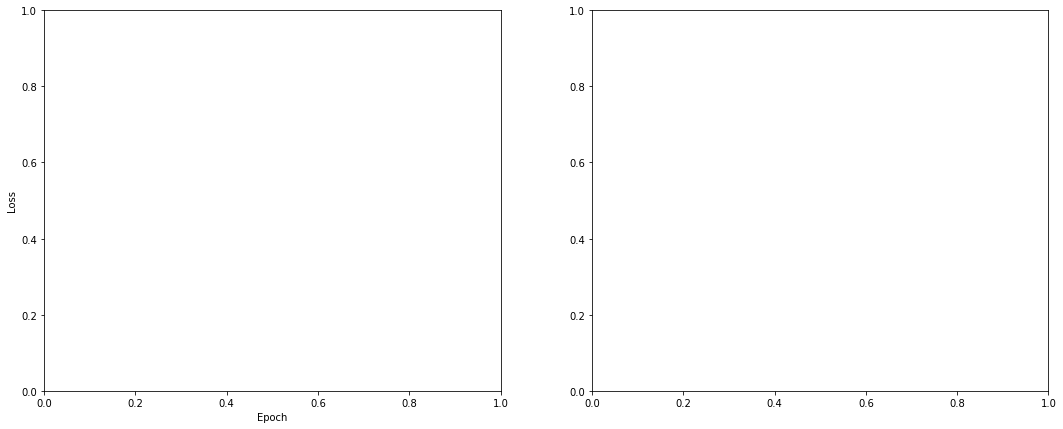

In [129]:
# -- Plotting --
f, axarr = plt.subplots(1, 2, figsize=(18, 7))

# Loss
ax = axarr[0]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(np.arange(epoch+1), discriminator_loss)

ax.legend(['Discriminator'])

ax = axarr[1]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(np.arange(epoch+1), generator_loss, linestyle="--")
ax.legend(['Generator']) 

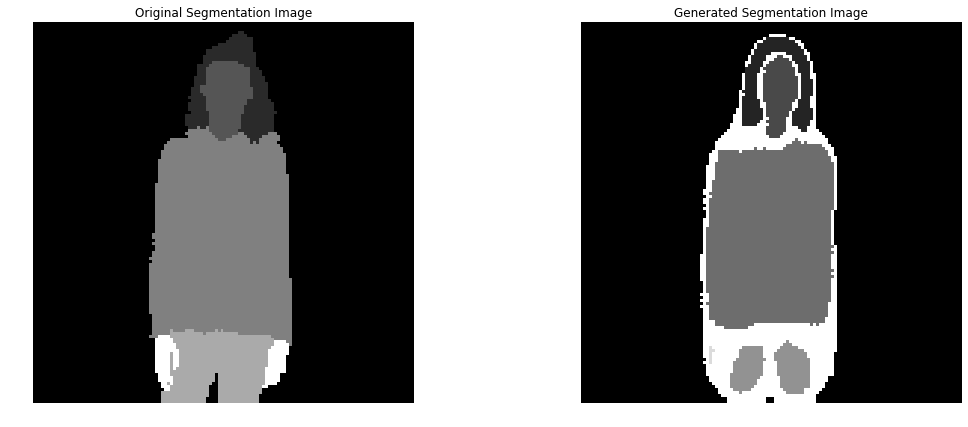

In [131]:
# -- Plotting --
f, axarr = plt.subplots(1, 2, figsize=(18, 7))

# Latent space samples
ax = axarr[1]
ax.set_title('Generated Segmentation Image')
ax.axis('off')

# Generate data
with torch.no_grad():
  z = torch.randn(batch_size, latent_dim, 1, 1)
  z = Variable(z, requires_grad=False).cpu().to(device)
  x_fake = generator1(z, downsampled_true, attributes_true)

index = 0

x_fake = x_fake[index]
#Minus since it's negative log likelihood that is used
threshold = -0.5
x_fake[0][x_fake[0] > threshold] = 0
x_fake[1][x_fake[1] > threshold] = 0
x_fake[2][x_fake[2] > threshold] = 0
x_fake[3][x_fake[3] > threshold] = 0
x_fake[4][x_fake[4] > threshold] = 0
x_fake[5][x_fake[5] > threshold] = 0
x_fake[6][x_fake[6] > threshold] = 0

x_fake[0][x_fake[0] < threshold] = 7
x_fake[1][x_fake[1] < threshold] = 6
x_fake[2][x_fake[2] < threshold] = 5
x_fake[3][x_fake[3] < threshold] = 4
x_fake[4][x_fake[4] < threshold] = 3
x_fake[5][x_fake[5] < threshold] = 2
x_fake[6][x_fake[6] < threshold] = 1

summation = x_fake[0] + x_fake[1] + x_fake[2] + x_fake[3] + x_fake[4] + x_fake[5] + x_fake[6] 
ax.imshow(summation.T.cpu(), cmap='gray')

ax = axarr[0]
ax.set_title('Original Segmentation Image')
ax.axis('off')
realSegmentation = segmentatedImage_true[index]

ax.imshow(realSegmentation.T.cpu(), cmap='gray')

## Training Gan 2

## Dataloader

In [103]:
batch_size = 64

datasetTwo = DeepFashDataset.DatasetSecond(Data_G2, downsampledData, Data_attributes)

num_train = 100
indices = list(range(num_train))
split = int(math.floor(0.1 * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(valid_idx)

train_loader2 = DataLoader(datasetTwo, batch_size=batch_size, pin_memory=cuda, sampler = train_sampler)
test_sampler2 = DataLoader(datasetTwo, batch_size=batch_size, pin_memory=cuda, sampler = test_sampler)

## Training

In [104]:
loss = torch.nn.BCELoss()
loss_img = torch.nn.L1Loss()
discriminator_loss, generator_loss = [], []

num_epochs = 5
lambda_fake = 0.9
lambda_mismatch = 1 - lambda_fake
latent_dim = 100

discriminator_optim2 = torch.optim.Adam(discriminator2.parameters(), 2e-4, betas=(0.5, 0.999))
generator_optim2 = torch.optim.Adam(generator2.parameters(), 2e-4, betas=(0.5, 0.999))

for epoch in range(num_epochs):
  batch_d_loss2, batch_g_loss2 = [], []
  i = 0
  start = time.time()
  for attributes, data_processed, image, wrong_data, wrong_processed, segmentatedImage_onehot, segmentatedImage_onehot_wrong in train_loader2:
    batch_size = attributes.size(0)
    # True data is given label 1, while fake data is given label 0
    true_label = torch.ones(batch_size, 1, 1, 1).to(device)
    fake_label = torch.zeros(batch_size, 1, 1, 1).to(device)
    attributes = attributes.view(attributes.size(0), attributes.size(1), 1, 1)
    
    ## Discriminator ##
    
    discriminator_optim2.zero_grad()
    
    attributesX4 = torch.cat((attributes, attributes, attributes, attributes), 2)
    attributesX4 = torch.cat((attributesX4, attributesX4, attributesX4, attributesX4), 3)

    attributes_true = Variable(attributes).to(device, dtype=torch.float)
    attributesX4_true = Variable(attributesX4).to(device, dtype=torch.float)
    image_true = Variable(image).to(device, dtype=torch.float)
    image_wrong = Variable(wrong_data).to(device, dtype=torch.float)
    downsampled_wrong = Variable(wrong_processed).to(device, dtype=torch.float)
    segmentatedImage_onehot_true = Variable(segmentatedImage_onehot.permute(0,3,1,2)).to(device, dtype=torch.float)
    segmentatedImage_onehot_wrong2 = Variable(segmentatedImage_onehot_wrong.permute(0,3,1,2)).to(device, dtype=torch.float)
    
    #Step 1 real data through discriminator and backprobagate.

    output = discriminator2(image_true, segmentatedImage_onehot_true, attributesX4_true)
    
    error_true = loss(output, true_label)
    error_true.backward()

    ### Step 2
    output = discriminator2(image_wrong ,segmentatedImage_onehot_wrong2,attributesX4_true)
    
    error_notmatch = lambda_mismatch * loss(output, fake_label) 
    
    error_notmatch.backward()
    
    ###

    # Step 3 noise through generator.
    z = torch.randn(batch_size, latent_dim, 1, 1)
    z = Variable(z).to(device, dtype=torch.float)
    attributes_true_G = Variable(attributes).to(device, dtype=torch.float)     
    segmentatedImage_true_G = Variable(segmentatedImage_onehot.permute(0,3,1,2)).to(device, dtype=torch.float)
    G2 = generator2(z, segmentatedImage_true_G, attributes_true_G)


    # send the data through discriminator and update

    #downsampled_G_Var = Variable(test2).to(device, dtype=torch.float)
    attributesX4_true_test = Variable(attributesX4).to(device, dtype=torch.float)   

    output = discriminator2(G2.detach(), segmentatedImage_true_G.detach(), attributesX4_true_test.detach())


    error_fake = lambda_fake * loss(output, fake_label)
    error_fake.backward()
    discriminator_optim2.step()

    ## GENERATOR 2 ##
    
    # Step 4 send the data through discriminator and update again and propagate generator error and update weights
    generator_optim2.zero_grad()
    output = discriminator2(G2, segmentatedImage_true_G, attributesX4_true_test)

    error_generator = loss(output, true_label)
    
    ## error sequence
    target = Variable(image_true).to(device,dtype=torch.float)
    error_seg = 100*loss_img(G2,target)
    error_total = error_generator + error_seg
    error_total.backward()
    
    generator_optim2.step()
    
    error1 = ((error_true + error_fake + error_true)/2).item()
    error2 = (error_total).item()
    
    batch_d_loss2.append(error1)
    batch_g_loss2.append(error2)
    
  batch_d_loss_mean = np.mean(batch_d_loss2)
  batch_g_loss_mean = np.mean(batch_g_loss2)
    
  if epoch % 5 == 0:
    print("Epoch tid: {}".format(time.time() - start))
    print("Epoch {}:".format(epoch))
    print("D loss: {}".format(batch_d_loss_mean))
    print("G loss: {}".format(batch_g_loss_mean))


  discriminator_loss.append(batch_d_loss_mean)
  generator_loss.append(batch_g_loss_mean)

Epoch tid: 3.0670876502990723
Epoch 0:
D loss: 0.9896998405456543
G loss: 37.6105842590332


### Results

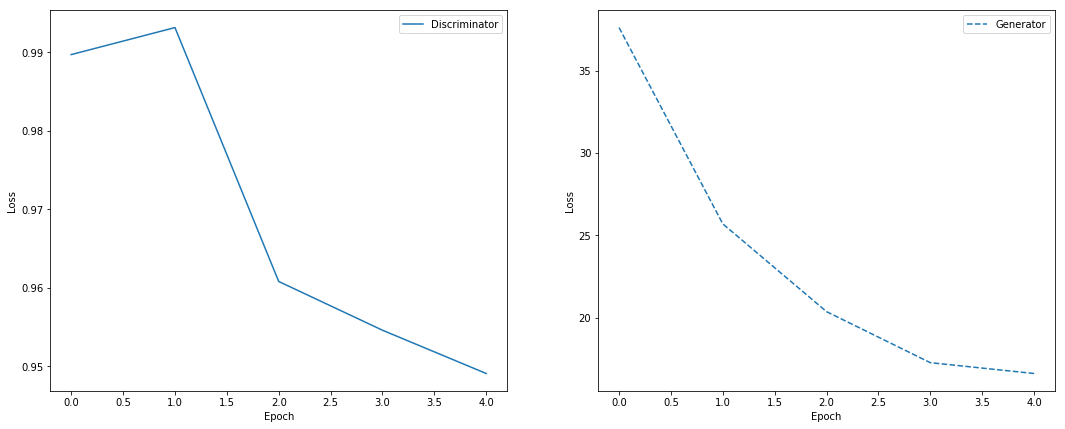

In [105]:
# -- Plotting --
f, axarr = plt.subplots(1, 2, figsize=(18, 7))

# Loss
ax = axarr[0]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(np.arange(epoch+1), discriminator_loss)

ax.legend(['Discriminator'])

ax = axarr[1]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(np.arange(epoch+1), generator_loss, linestyle="--")
ax.legend(['Generator'])   

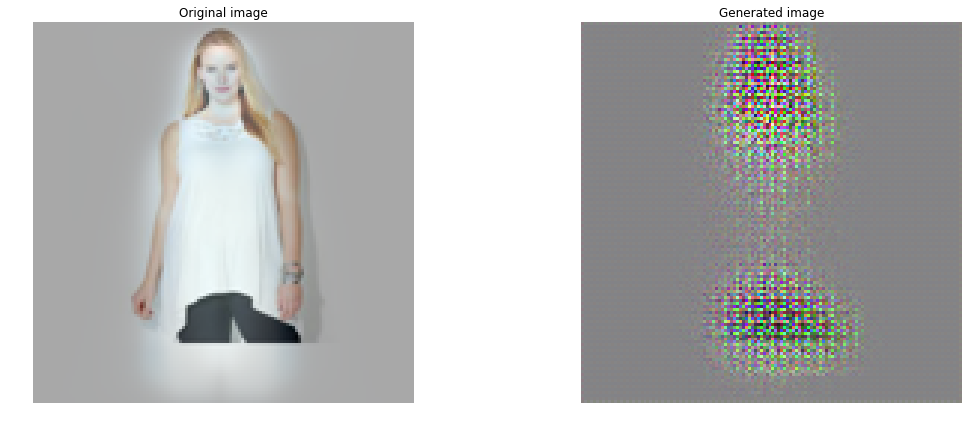

In [113]:
# -- Plotting --
f, axarr = plt.subplots(1, 2, figsize=(18, 7))

# Latent space samples
ax = axarr[1]
ax.set_title('Samples from generator')
ax.axis('off')

# Generate data
with torch.no_grad():
  z = torch.randn(batch_size, latent_dim, 1, 1)
  z = Variable(z, requires_grad=False).cpu().to(device)
  x_fake = generator2(z, segmentatedImage_onehot_true, attributes_true)

index = 0

ax = axarr[1]
ax.set_title('Generated image')
ax.axis('off')

summation = normalize_image(x_fake[index])
ax.imshow(summation.T.cpu(), cmap='gray')

ax = axarr[0]
ax.set_title('Original image')
ax.axis('off')

imagetest = image[index]
imagetest = normalize_image(imagetest)
ax.imshow(imagetest.T.cpu(), cmap='gray')